# SHAP Analysis for top 5 models of LSTM/GRU models

## Set up

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import random
import tempfile
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras import backend as K

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
path='drive/MyDrive/Capstone(Team10)/code'


file = tf.keras.utils

with open(path+'/data/X_data_full.pkl','rb') as f:
  X_data=pickle.load(f)

raw_df = pd.read_csv(path+'/data/rawdata_USA.csv', index_col=0, parse_dates=True)
raw_df.index.name='date'

metadata=pd.read_csv(path+'/data/metadata_final.csv')

X_data.head(5)

Mounted at /content/drive


LCEAPR01  XTIMVA01  PRMNTO01  MABMM301  PRCNTO01  STMNIS01  \
date                                                                     
1973-01-01  0.004975  0.047149  0.007775  0.009922  0.013699 -0.006349   
1973-02-01  0.002478  0.044624  0.015954  0.004679  0.020691 -0.006390   
1973-03-01  0.004938 -0.012775  0.001725  0.001473  0.014144  0.006390   
1973-04-01  0.004914 -0.009876 -0.001709  0.005382 -0.027771  0.006349   
1973-05-01  0.004890  0.062043  0.006343  0.008624 -0.010260  0.000000   

            SLWHTO02  ODMNTO02  XTEXVA01  CCRETT01  ...  IRLTLT01  IR3TCD01  \
date                                                ...                       
1973-01-01  0.040962  0.014942  0.084607 -0.011478  ...      0.10      0.38   
1973-02-01  0.016314  0.023197  0.022962 -0.041932  ...      0.18      0.53   
1973-03-01  0.019215  0.022260  0.046380 -0.035349  ...      0.07      0.71   
1973-04-01  0.021154 -0.008716  0.033822  0.002986  ...     -0.04      0.26   
1973-05-01  0.014101  0.006697  0.012248 -0.009481  ...      0.18      0.24   

             BSPRTE02  LREMTTTT  LRHU24TT  LRUNTTTT  BSCURT02  3MTBILL  10YT  \
date                                                                           
1973-01-01   2.569360      -0.2      -1.1      -0.3    0.3890     0.34  0.10   
1973-02-01  -6.665425       0.4       0.7       0.1    1.1154     0.19  0.18   
1973-03-01   0.992926       0.3      -0.5      -0.1   -0.1107     0.49  0.07   
1973-04-01  -3.104780      -0.1       0.6       0.1   -0.4168     0.17 -0.04   
1973-05-01 -13.030239       0.0      -0.3      -0.1    0.2500     0.10  0.18   

            103SPREAD  
date                   
1973-01-01       1.05  
1973-02-01       1.04  
1973-03-01       0.62  
1973-04-01       0.41  
1973-05-01       0.49  

[5 rows x 45 columns]

In [3]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    if type(Xs)==pd.core.frame.DataFrame:
      for i in range(len(X) - time_steps + 1):
          v = X.iloc[i:(i + time_steps)].values
          Xs.append(v)
          ys.append(y.iloc[i + time_steps-1].values)
          Xs=np.array(Xs)
          ys=np.array(ys)

    else:
      for i in range(len(X) - time_steps + 1):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps-1])

    return np.array(Xs), np.array(ys)

## import top 5 models from df_selection.pkl file
* top 5 models among all LSTM/GRU candidates in terms of high macro averaging recall (based on 3-CV)

In [4]:
with open(path+'/model/df_selection.pkl', 'rb') as f:
  df_selection = pickle.load(f)

model_name_list=[x for (x,y) in df_selection.iloc[:5].index]
es_list=[y for (x,y) in df_selection.iloc[:5].index]
print(model_name_list, es_list)

df_selection.head(5)

['clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None', 'clf_y_oecd_gru_18_b12_ep100_h10_d0.2_None', 'clf_y_oecd_gru_18_b12_ep100_h10_d0.2_L1_0.01', 'clf_y_oecd_lstm_12_b12_ep100_h30_d0.2_None', 'clf_y_oecd_gru_12_b12_ep100_h30_d0.2_None'] [True, True, True, False, True]


val       auc  \
model                                        early_stopping                  
clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None   True            1.0  0.634259   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_None    True            1.0  0.433333   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_L1_0.01 True            1.0  0.585185   
clf_y_oecd_lstm_12_b12_ep100_h30_d0.2_None   False           1.0  0.447917   
clf_y_oecd_gru_12_b12_ep100_h30_d0.2_None    True            1.0  0.464120   

                                                             recall_0  \
model                                        early_stopping             
clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None   True            0.666667   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_None    True            0.518519   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_L1_0.01 True            0.629630   
clf_y_oecd_lstm_12_b12_ep100_h30_d0.2_None   False           0.666667   
clf_y_oecd_gru_12_b12_ep100_h30_d0.2_None    True            0.629630   

                                                             recall_1  \
model                                        early_stopping             
clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None   True            0.602564   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_None    True            0.680702   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_L1_0.01 True            0.563158   
clf_y_oecd_lstm_12_b12_ep100_h30_d0.2_None   False           0.463333   
clf_y_oecd_gru_12_b12_ep100_h30_d0.2_None    True            0.476667   

                                                             recall_2  \
model                                        early_stopping             
clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None   True              -100.0   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_None    True              -100.0   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_L1_0.01 True              -100.0   
clf_y_oecd_lstm_12_b12_ep100_h30_d0.2_None   False             -100.0   
clf_y_oecd_gru_12_b12_ep100_h30_d0.2_None    True              -100.0   

                                                             final_auc  \
model                                        early_stopping              
clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None   True             0.870536   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_None    True             0.642857   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_L1_0.01 True             0.886161   
clf_y_oecd_lstm_12_b12_ep100_h30_d0.2_None   False            0.888393   
clf_y_oecd_gru_12_b12_ep100_h30_d0.2_None    True             0.863839   

                                                             final_recall_0  \
model                                        early_stopping                   
clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None   True                  0.732143   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_None    True                  0.803571   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_L1_0.01 True                  0.589286   
clf_y_oecd_lstm_12_b12_ep100_h30_d0.2_None   False                 0.732143   
clf_y_oecd_gru_12_b12_ep100_h30_d0.2_None    True                  0.821429   

                                                             final_recall_1  \
model                                        early_stopping                   
clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None   True                      1.00   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_None    True                      0.25   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_L1_0.01 True                      1.00   
clf_y_oecd_lstm_12_b12_ep100_h30_d0.2_None   False                     1.00   
clf_y_oecd_gru_12_b12_ep100_h30_d0.2_None    True                      0.75   

                                                             final_recall_2  \
model                                        early_stopping                   
clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None   True                    -100.0   
clf_y_oecd_gru_18_b12_ep100_h10_d0.2_None    True                    -100.0   
clf_y_oecd_gru_18_b12_ep100_h10_d0.

In [5]:
nb_path = '/content/notebooks'
sys.path.insert(0,nb_path)
!pip install shap

tf.compat.v1.disable_v2_behavior()  ## input type err solved
from tensorflow.keras.models import load_model
import shap
from sklearn.metrics import confusion_matrix,classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.9 MB/s eta 0:00:00


Instructions for updating:
non-resource variables are not supported in the long term
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Train and evaluate top 5 models and calculate SHAP values

* train each model with (train + validation) dataset and evaluate for final test dataset (last 5 years)
-- final train dataset = 74.12~17.12 (The first 23 month from 73.1 were removed due to application of 24month-timesteps)
-- final test dataset = 18.1~22.12

* for each model
-- train the model
-- evaluation (classification report & confusion matrix)
-- calculate SHAP values for train and test dataset


Train on 517 samples
Epoch 1/100
517/517 [==============================] - 1s 2ms/sample - loss: 0.6572 - auc: 0.6659 - accuracy: 0.0000e+00 - recall: 0.6209 - precision: 0.6209 - recall_0: 0.6962 - recall_1: 0.5223
Epoch 2/100
517/517 [==============================] - 1s 1ms/sample - loss: 0.5717 - auc: 0.8103 - accuracy: 0.0000e+00 - recall: 0.7369 - precision: 0.7369 - recall_0: 0.8601 - recall_1: 0.5759
Epoch 3/100
517/517 [==============================] - 1s 1ms/sample - loss: 0.5062 - auc: 0.8651 - accuracy: 0.0000e+00 - recall: 0.7911 - precision: 0.7911 - recall_0: 0.9078 - recall_1: 0.6384
Epoch 4/100
517/517 [==============================] - 1s 1ms/sample - loss: 0.4366 - auc: 0.9025 - accuracy: 0.0000e+00 - recall: 0.8240 - precision: 0.8240 - recall_0: 0.9147 - recall_1: 0.7054
Epoch 5/100
517/517 [==============================] - 1s 1ms/sample - loss: 0.3706 - auc: 0.9332 - accuracy: 0.0000e+00 - recall: 0.8627 - precision: 0.8627 - recall_0: 0.9317 - recall_1: 0.7723

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


0 ranked model clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None shows
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        56
           1       0.60      0.75      0.67         4

    accuracy                           0.95        60
   macro avg       0.79      0.86      0.82        60
weighted avg       0.96      0.95      0.95        60



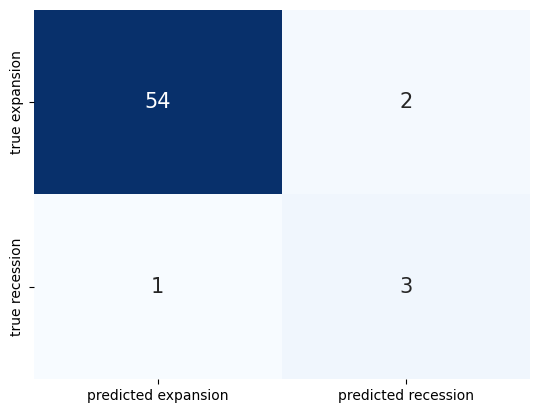

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



[0.5159158110618591, 0.9595833, 0.0, 0.95, 0.95, 0.96428573, 0.75]
Train on 523 samples
Epoch 1/100
523/523 [==============================] - 1s 2ms/sample - loss: 0.6512 - auc_2: 0.6827 - accuracy: 0.0000e+00 - recall_2: 0.6310 - precision_2: 0.6310 - recall_0: 0.6382 - recall_1: 0.6217
Epoch 2/100
523/523 [==============================] - 0s 888us/sample - loss: 0.5456 - auc_2: 0.7971 - accuracy: 0.0000e+00 - recall_2: 0.7094 - precision_2: 0.7094 - recall_0: 0.7952 - recall_1: 0.6000
Epoch 3/100
523/523 [==============================] - 0s 824us/sample - loss: 0.4994 - auc_2: 0.8388 - accuracy: 0.0000e+00 - recall_2: 0.7533 - precision_2: 0.7533 - recall_0: 0.8430 - recall_1: 0.6391
Epoch 4/100
523/523 [==============================] - 0s 843us/sample - loss: 0.4422 - auc_2: 0.8811 - accuracy: 0.0000e+00 - recall_2: 0.7820 - precision_2: 0.7820 - recall_0: 0.8464 - recall_1: 0.7000
Epoch 5/100
523/523 [==============================] - 1s 976us/sample - loss: 0.4211 - auc_2: 0.8

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


1 ranked model clf_y_oecd_gru_18_b12_ep100_h10_d0.2_None shows
              precision    recall  f1-score   support

           0       0.98      0.75      0.85        56
           1       0.18      0.75      0.29         4

    accuracy                           0.75        60
   macro avg       0.58      0.75      0.57        60
weighted avg       0.92      0.75      0.81        60



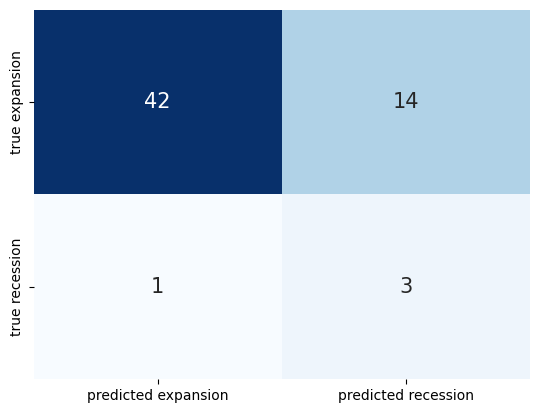

[0.47991982102394104, 0.86375, 0.0, 0.75, 0.75, 0.75, 0.75]


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


Train on 523 samples
Epoch 1/100
523/523 [==============================] - 1s 1ms/sample - loss: 1.3782 - auc_4: 0.5415 - accuracy: 0.0000e+00 - recall_4: 0.5277 - precision_4: 0.5277 - recall_0: 0.5939 - recall_1: 0.4435
Epoch 2/100
523/523 [==============================] - 0s 587us/sample - loss: 1.0942 - auc_4: 0.7167 - accuracy: 0.0000e+00 - recall_4: 0.6539 - precision_4: 0.6539 - recall_0: 0.7884 - recall_1: 0.4826
Epoch 3/100
523/523 [==============================] - 0s 512us/sample - loss: 0.8885 - auc_4: 0.8137 - accuracy: 0.0000e+00 - recall_4: 0.7304 - precision_4: 0.7304 - recall_0: 0.8908 - recall_1: 0.5261
Epoch 4/100
523/523 [==============================] - 0s 491us/sample - loss: 0.7604 - auc_4: 0.8577 - accuracy: 0.0000e+00 - recall_4: 0.7514 - precision_4: 0.7514 - recall_0: 0.9044 - recall_1: 0.5565
Epoch 5/100
523/523 [==============================] - 0s 515us/sample - loss: 0.6673 - auc_4: 0.8941 - accuracy: 0.0000e+00 - recall_4: 0.8107 - precision_4: 0.8107

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


2 ranked model clf_y_oecd_gru_18_b12_ep100_h10_d0.2_L1_0.01 shows
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        56
           1       0.11      0.25      0.15         4

    accuracy                           0.82        60
   macro avg       0.53      0.55      0.53        60
weighted avg       0.89      0.82      0.85        60



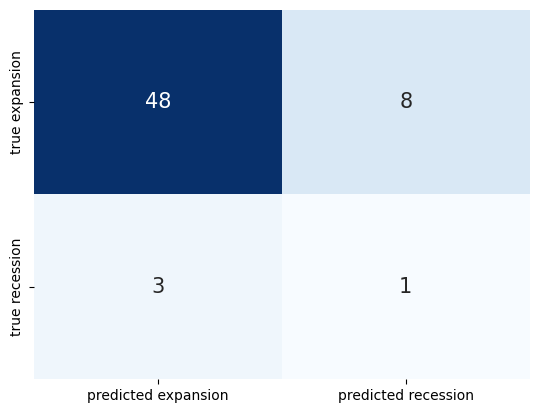

[1.0454771836598715, 0.8923611, 0.0, 0.81666666, 0.81666666, 0.85714287, 0.25]


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


Train on 529 samples
Epoch 1/100
529/529 [==============================] - 1s 1ms/sample - loss: 1.2715 - auc_6: 0.7208 - accuracy: 0.0000e+00 - recall_6: 0.6805 - precision_6: 0.6805 - recall_0: 0.6894 - recall_1: 0.6695
Epoch 2/100
529/529 [==============================] - 0s 390us/sample - loss: 0.5628 - auc_6: 0.8577 - accuracy: 0.0000e+00 - recall_6: 0.7940 - precision_6: 0.7940 - recall_0: 0.8089 - recall_1: 0.7754
Epoch 3/100
529/529 [==============================] - 0s 439us/sample - loss: 0.4032 - auc_6: 0.9111 - accuracy: 0.0000e+00 - recall_6: 0.8507 - precision_6: 0.8507 - recall_0: 0.8874 - recall_1: 0.8051
Epoch 4/100
529/529 [==============================] - 0s 442us/sample - loss: 0.3294 - auc_6: 0.9357 - accuracy: 0.0000e+00 - recall_6: 0.8563 - precision_6: 0.8563 - recall_0: 0.8635 - recall_1: 0.8475
Epoch 5/100
529/529 [==============================] - 0s 489us/sample - loss: 0.2582 - auc_6: 0.9592 - accuracy: 0.0000e+00 - recall_6: 0.8941 - precision_6: 0.8941

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


3 ranked model clf_y_oecd_lstm_12_b12_ep100_h30_d0.2_None shows
              precision    recall  f1-score   support

           0       1.00      0.57      0.73        56
           1       0.14      1.00      0.25         4

    accuracy                           0.60        60
   macro avg       0.57      0.79      0.49        60
weighted avg       0.94      0.60      0.70        60



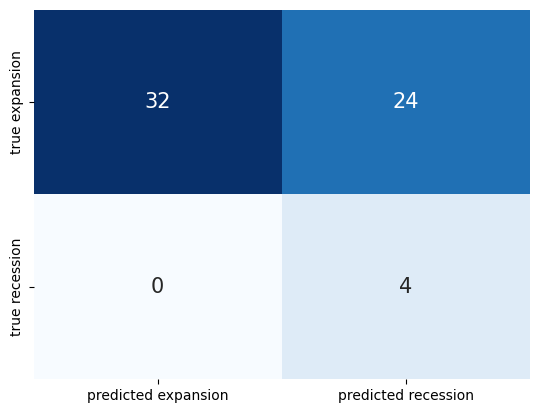

[3.3523840506871543, 0.5772222, 0.0, 0.6, 0.6, 0.5714286, 1.0]


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


Train on 529 samples
Epoch 1/100
529/529 [==============================] - 1s 1ms/sample - loss: 0.6074 - auc_8: 0.7327 - accuracy: 0.0000e+00 - recall_8: 0.6673 - precision_8: 0.6673 - recall_0: 0.7577 - recall_1: 0.5551
Epoch 2/100
529/529 [==============================] - 0s 439us/sample - loss: 0.4481 - auc_8: 0.8752 - accuracy: 0.0000e+00 - recall_8: 0.7864 - precision_8: 0.7864 - recall_0: 0.8805 - recall_1: 0.6695
Epoch 3/100
529/529 [==============================] - 0s 440us/sample - loss: 0.3952 - auc_8: 0.9069 - accuracy: 0.0000e+00 - recall_8: 0.8318 - precision_8: 0.8318 - recall_0: 0.9078 - recall_1: 0.7373
Epoch 4/100
529/529 [==============================] - 0s 430us/sample - loss: 0.3279 - auc_8: 0.9390 - accuracy: 0.0000e+00 - recall_8: 0.8696 - precision_8: 0.8696 - recall_0: 0.9113 - recall_1: 0.8178
Epoch 5/100
529/529 [==============================] - 0s 459us/sample - loss: 0.2580 - auc_8: 0.9623 - accuracy: 0.0000e+00 - recall_8: 0.8998 - precision_8: 0.8998

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


4 ranked model clf_y_oecd_gru_12_b12_ep100_h30_d0.2_None shows
              precision    recall  f1-score   support

           0       1.00      0.61      0.76        56
           1       0.15      1.00      0.27         4

    accuracy                           0.63        60
   macro avg       0.58      0.80      0.51        60
weighted avg       0.94      0.63      0.72        60



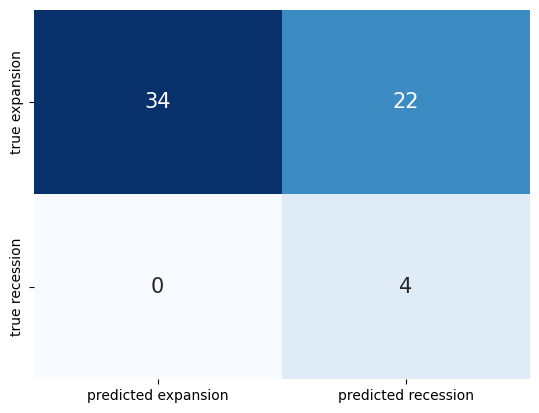

[0.5543815970420838, 0.7570833, 0.0, 0.6333333, 0.6333333, 0.60714287, 1.0]


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


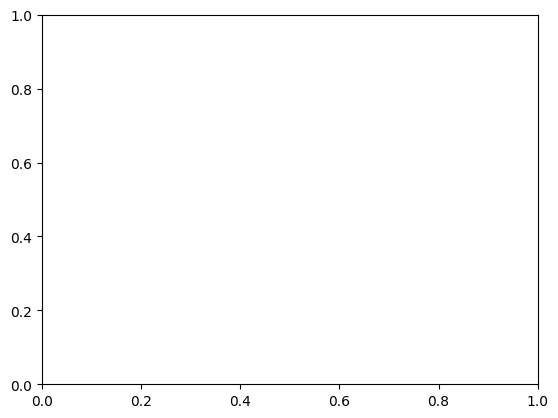

In [6]:
data=[]
shap_test=[]
shap_train=[]
scores_list=[]
explainer_list=[]
y_pred_prob_list=[]
y_pred_list=[]
y_test_list=[]
y_fit_prob_list=[]
y_fit_list=[]
y_train_list=[]

features_list=[]
test_year=5

for idx, (model_name, es) in enumerate(zip(model_name_list, es_list)):

  ytype= model_name.split('_')[2]  # options: nber, oecd, or agg
  model_type=model_name.split('_')[3]  # options: lstm, gru
  threshold=50

  if es==True:
    folder_path=path+'/model/change_test{}_{}_{}_es'.format(test_year, ytype, model_type)
  else:
    folder_path=path+'/model/change_test{}_{}_{}'.format(test_year, ytype, model_type)

  with open(path+'/data/X_data_full.pkl','rb') as f:
    X_data=pickle.load(f)

  y_type='y_{}'.format(ytype)
  n_splits=3
  test_year=5

  y=raw_df[y_type]
  y_data=y[-(threshold*12+6):-6]

  time_step=int(model_name.split('_')[4])
  batch_size=int(model_name.split('_')[5][1:])
  num_epochs=int(model_name.split('_')[6][2:])
  num_layer=int(model_name.split('_')[7][1:])
  dropout=float(model_name.split('_')[8][1:])
  method=model_name.split('_')[9]

  if method!='None':
    reg_factor=float(model_name.split('_')[10])
  else:
    reg_factor=0

  if y_type=='y_agg':
      num_classes=3
  else:
      num_classes=2

  ## set rendom seed for reproducibility
  np.random.seed(699)
  os.environ['PYTHONHASHSEED'] = '699'
  random.seed(699)
  tf.compat.v1.set_random_seed(699)
  tf.keras.utils.set_random_seed(699)

  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)


  ## whole train and test dataset
  X_train=X_data.iloc[:-test_year*12]
  y_train=y_data.iloc[:-test_year*12]
  X_test=X_data.iloc[-test_year*12-time_step+1:]
  y_test=y_data.iloc[-test_year*12-time_step+1:]

  ## standard scaling
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  ##make dataset to feed into the model (dataset split into timestep unit)
  trainx, trainy = create_dataset(X_train, y_train, time_step)
  testx, testy = create_dataset(X_test, y_test, time_step)
  trainy = to_categorical(trainy, num_classes=num_classes)
  testy = to_categorical(testy, num_classes=num_classes)

  data.append([trainx, trainy, testx, testy])

  ## assign metrics to calculate for final test dataset
  if y_type!='y_agg':
    metrics=['AUC','Accuracy','Recall','Precision',
            Recall(class_id=0, name='recall_0'),
            Recall(class_id=1, name='recall_1')]

  else:
    metrics=['AUC','Accuracy','Recall','Precision',
            Recall(class_id=0, name='recall_0'),
            Recall(class_id=1, name='recall_1'),
            Recall(class_id=2, name='recall_2')]

  final_model=load_model(folder_path+'/{}.h5'.format(model_name), compile=False)
  final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

  ## execute early stop according to recall for positive class
  if es==True:
    early_stop = EarlyStopping(monitor='recall_1', patience=5, verbose=1,restore_best_weights=True)
    history=final_model.fit(trainx, trainy, epochs=num_epochs, batch_size=batch_size, callbacks=[early_stop])
  else:
    history=final_model.fit(trainx, trainy, epochs=num_epochs, batch_size=batch_size)

  ## return prediction for train and test dataset
  scores=final_model.evaluate(testx, testy, verbose=0)
  y_pred_prob=final_model.predict(testx)
  y_pred=final_model.predict(testx).argmax(axis=1)
  y_test=testy.argmax(axis=1)

  y_fit_prob=final_model.predict(trainx)
  y_fit=final_model.predict(trainx).argmax(axis=1)
  y_train=trainy.argmax(axis=1)

  scores_list.append(scores)
  y_pred_prob_list.append(y_pred_prob)
  y_pred_list.append(y_pred)
  y_test_list.append(y_test)

  y_fit_prob_list.append(y_fit_prob)
  y_fit_list.append(y_fit)
  y_train_list.append(y_train)

  ## print classification report and confusion matrix
  print('{} ranked model {} shows'.format(idx, model_name))
  print(classification_report(y_test, y_pred))
  cf_matrix = confusion_matrix(y_test, y_pred)
  df=pd.DataFrame(cf_matrix, index=['true expansion','true recession'], columns=['predicted expansion', 'predicted recession'])
  sns.heatmap(df, annot=True, annot_kws={'size': 15},
              cmap='Blues', cbar=False)
  plt.show()
  plt.cla()

  print(scores)

  ## generate shap explainer and calculate shap values
  explainer=shap.DeepExplainer(final_model, trainx)
  values_test=explainer.shap_values(np.array(testx))
  values_train=explainer.shap_values(np.array(trainx))

  ## save the final models in the model folder
  final_model.save(path+'/model/{}_top{}_alltrained.h5'.format(model_name, idx))
  explainer_list.append(explainer)
  shap_test.append(values_test)
  shap_train.append(values_train)

  selected_features=list(X_data.columns)

  features_list.append(selected_features)

## save the final results of top 5 models in analysis_dict.pkl file


In [7]:
analysis_dict={'model_name':model_name_list, 'early_stopping':es_list, 'data':data,
               'shap_test':shap_test, 'shap_train':shap_train, 'scores':scores_list,
               'y_pred_prob':y_pred_prob_list, 'y_pred':y_pred_list,  #'explainer':explainer_list,
               'y_test':y_test_list, 'y_fit_prob':y_fit_prob_list, 'y_fit':y_fit_list,
               'y_train':y_train_list, 'selected_features':features_list}

with open(path+'/model/analysis_dict.pkl', 'wb') as f:
  pickle.dump(analysis_dict, f)

In [8]:
with open(path+'/model/analysis_dict.pkl', 'rb') as f:
  analysis_dict=pickle.load(f)

data=analysis_dict['data']
shap_test=analysis_dict['shap_test']
shap_train=analysis_dict['shap_train']
scores_list=analysis_dict['scores']
y_pred_prob_list=analysis_dict['y_pred_prob']
y_pred_list=analysis_dict['y_pred']
y_test_list=analysis_dict['y_test']
y_fit_prob_list=analysis_dict['y_fit_prob']
y_fit_list=analysis_dict['y_fit']
y_train_list=analysis_dict['y_train']
features_list=analysis_dict['selected_features']

In [17]:
## print roc auc score for top 5 models
for idx in range(5):
  print('roc auc score for {} ranked model:'.format(idx+1),roc_auc_score(y_test_list[idx], y_pred_prob_list[idx][:,1]))

roc auc score for 1 ranked model: 0.7678571428571429
roc auc score for 2 ranked model: 0.8660714285714286
roc auc score for 3 ranked model: 0.7410714285714285
roc auc score for 4 ranked model: 0.7455357142857143
roc auc score for 5 ranked model: 0.90625


## plot the prediction vs. true recession during final test period (18.1~22.12)

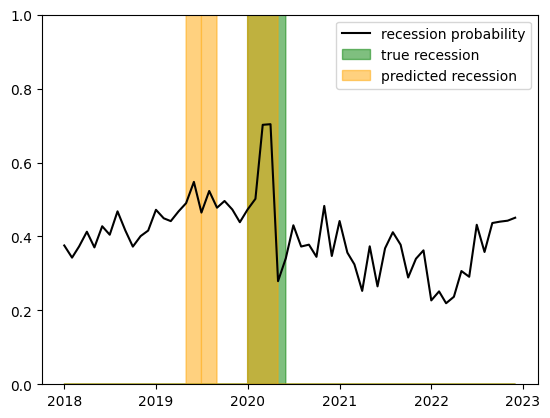

In [10]:

################# assign rank here! ########################
idx=0 ## rank = idx +1
test_year=5
##############################################################
y_pred_prob=y_pred_prob_list[idx]
y_pred=y_pred_list[idx]
y_test=y_test_list[idx]

plt.plot(X_data.index[-test_year*12:], y_pred_prob[:,1], color='black', label='recession probability')
plt.fill_between(X_data.index[-test_year*12:],0,y_test*1000, color='green', alpha=0.5, label='true recession')
plt.fill_between(X_data.index[-test_year*12:], 0, y_pred*1000, color='orange', alpha=0.5, label='predicted recession')
plt.ylim([0,1])
plt.legend()

## plot the prediction vs. true recession during final train period (74.12~17.12) for top 5 models


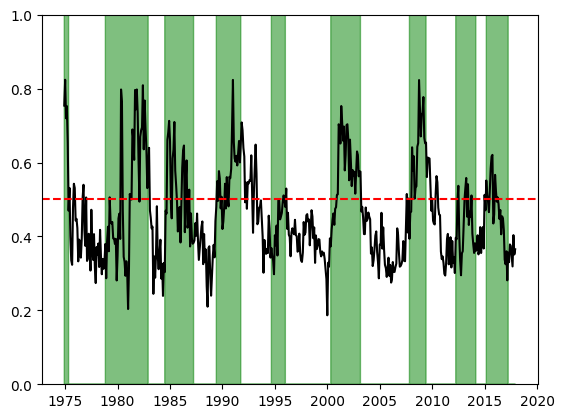

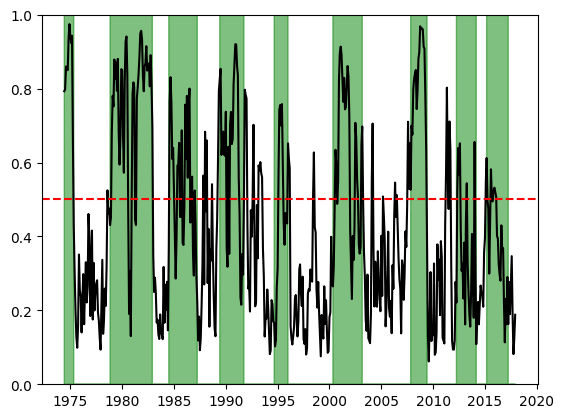

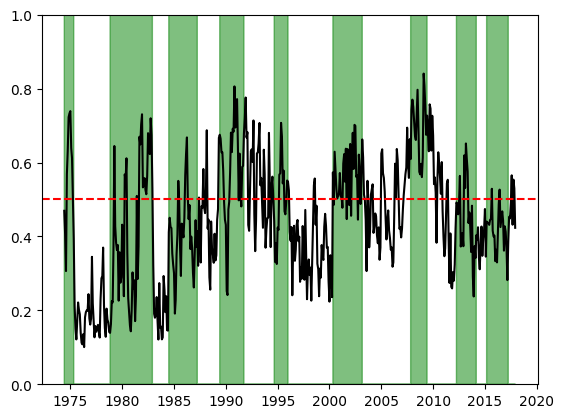

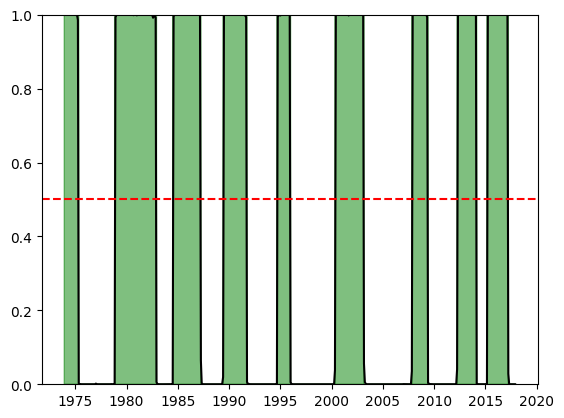

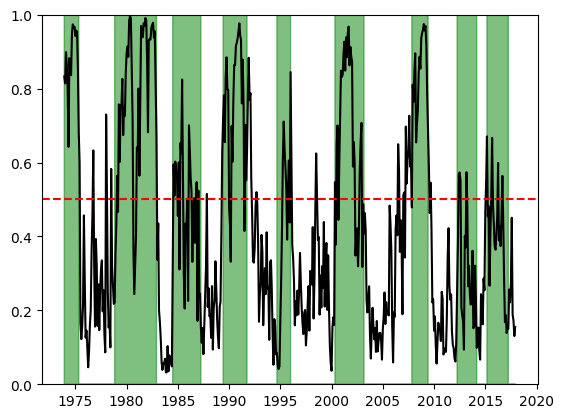

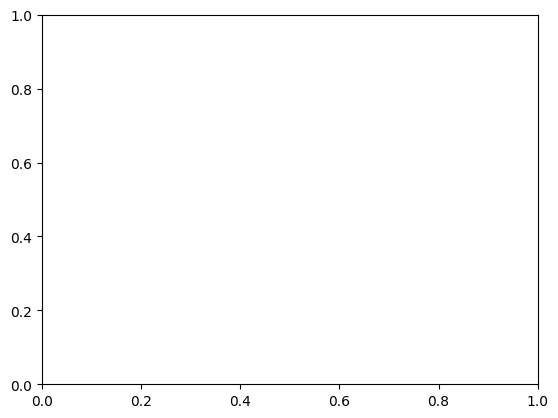

In [11]:
test_year=5

for idx in range(5):

  y_pred_prob=y_pred_prob_list[idx]
  y_pred=y_pred_list[idx]
  y_test=y_test_list[idx]

  y_fit_prob=y_fit_prob_list[idx]
  y_fit=y_fit_list[idx]
  y_train=y_train_list[idx]
  model_name=model_name_list[idx]

  time_step=int(model_name.split('_')[4])

  plt.plot(X_data.index[time_step-1:-test_year*12], y_fit_prob[:,1], color='black', label='recession probability')
  plt.fill_between(X_data.index[time_step-1:-test_year*12],0,y_train*1000, color='green', alpha=0.5, label='true recession')
  plt.axhline(y=0.5, color='r', linestyle='--')
  plt.ylim([0,1])

  plt.show()
  plt.cla()

## plot feature importance based on SHAP values


Top 1 ranked model clf_y_oecd_lstm_24_b12_ep100_h10_d0.2_None


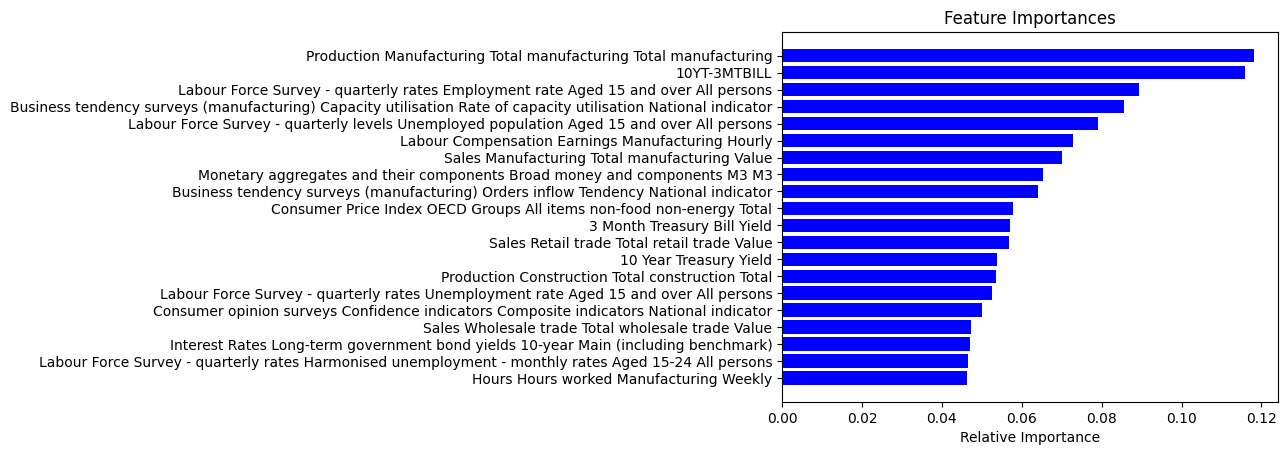

[('PRMNTO01', 'Production Manufacturing Total manufacturing Total manufacturing'), ('103SPREAD', '10YT-3MTBILL'), ('LREMTTTT', 'Labour Force Survey - quarterly rates Employment rate Aged 15 and over All persons'), ('BSCURT02', 'Business tendency surveys (manufacturing) Capacity utilisation Rate of capacity utilisation National indicator'), ('LFUNTTTT', 'Labour Force Survey - quarterly levels Unemployed population Aged 15 and over All persons'), ('LCEAMN01', 'Labour Compensation Earnings Manufacturing Hourly'), ('SLMNTO02', 'Sales Manufacturing Total manufacturing Value'), ('MABMM301', 'Monetary aggregates and their components Broad money and components M3 M3'), ('BSOITE02', 'Business tendency surveys (manufacturing) Orders inflow Tendency National indicator'), ('CPGRLE01', 'Consumer Price Index OECD Groups All items non-food non-energy Total'), ('3MTBILL', '3 Month Treasury Bill Yield'), ('SLRTTO02', 'Sales Retail trade Total retail trade Value'), ('10YT', '10 Year Treasury Yield'), ('

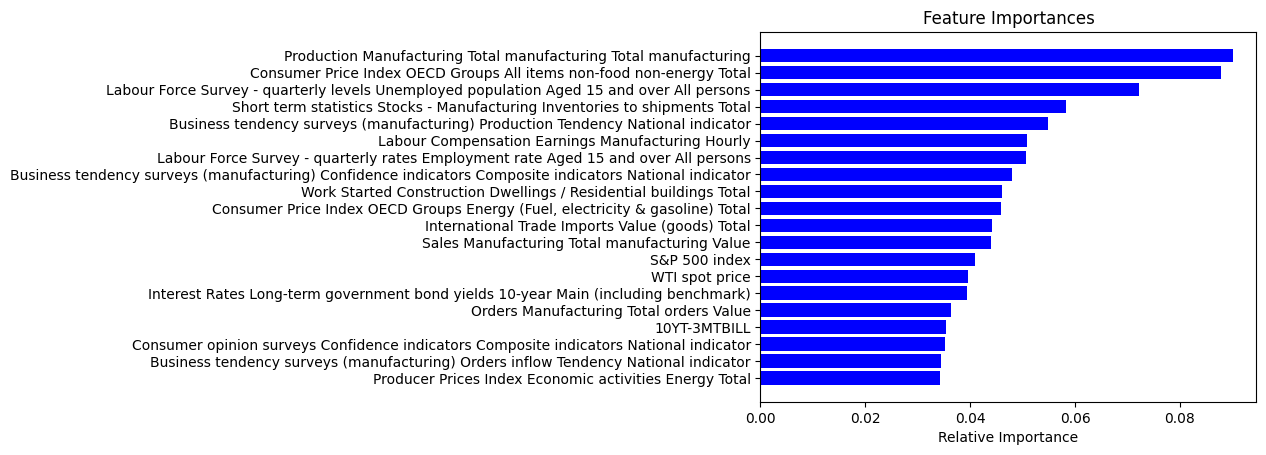

[('PRMNTO01', 'Production Manufacturing Total manufacturing Total manufacturing'), ('CPGRLE01', 'Consumer Price Index OECD Groups All items non-food non-energy Total'), ('LFUNTTTT', 'Labour Force Survey - quarterly levels Unemployed population Aged 15 and over All persons'), ('STMNIS01', 'Short term statistics Stocks - Manufacturing Inventories to shipments Total'), ('BSPRTE02', 'Business tendency surveys (manufacturing) Production Tendency National indicator'), ('LCEAMN01', 'Labour Compensation Earnings Manufacturing Hourly'), ('LREMTTTT', 'Labour Force Survey - quarterly rates Employment rate Aged 15 and over All persons'), ('BSCICP02', 'Business tendency surveys (manufacturing) Confidence indicators Composite indicators National indicator'), ('WSCNDW01', 'Work Started Construction Dwellings / Residential buildings Total'), ('CPGREN01', 'Consumer Price Index OECD Groups Energy (Fuel, electricity & gasoline) Total'), ('XTIMVA01', 'International Trade Imports Value (goods) Total'), ('S

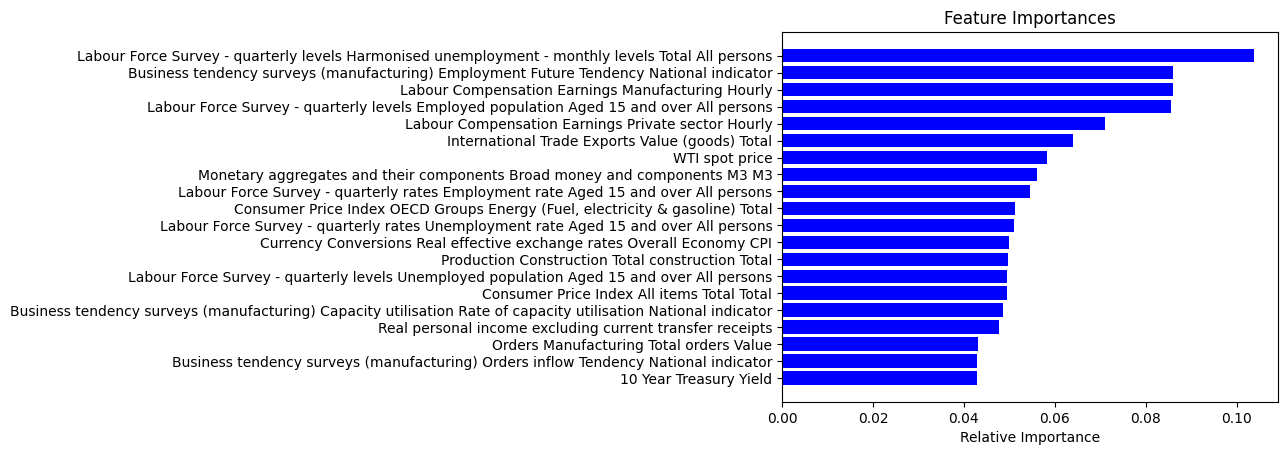

[('LFHUTTTT', 'Labour Force Survey - quarterly levels Harmonised unemployment - monthly levels Total All persons'), ('BSEMFT02', 'Business tendency surveys (manufacturing) Employment Future Tendency National indicator'), ('LCEAMN01', 'Labour Compensation Earnings Manufacturing Hourly'), ('LFEMTTTT', 'Labour Force Survey - quarterly levels Employed population Aged 15 and over All persons'), ('LCEAPR01', 'Labour Compensation Earnings Private sector Hourly'), ('XTEXVA01', 'International Trade Exports Value (goods) Total'), ('WTI', 'WTI spot price'), ('MABMM301', 'Monetary aggregates and their components Broad money and components M3 M3'), ('LREMTTTT', 'Labour Force Survey - quarterly rates Employment rate Aged 15 and over All persons'), ('CPGREN01', 'Consumer Price Index OECD Groups Energy (Fuel, electricity & gasoline) Total'), ('LRUNTTTT', 'Labour Force Survey - quarterly rates Unemployment rate Aged 15 and over All persons'), ('CCRETT01', 'Currency Conversions Real effective exchange r

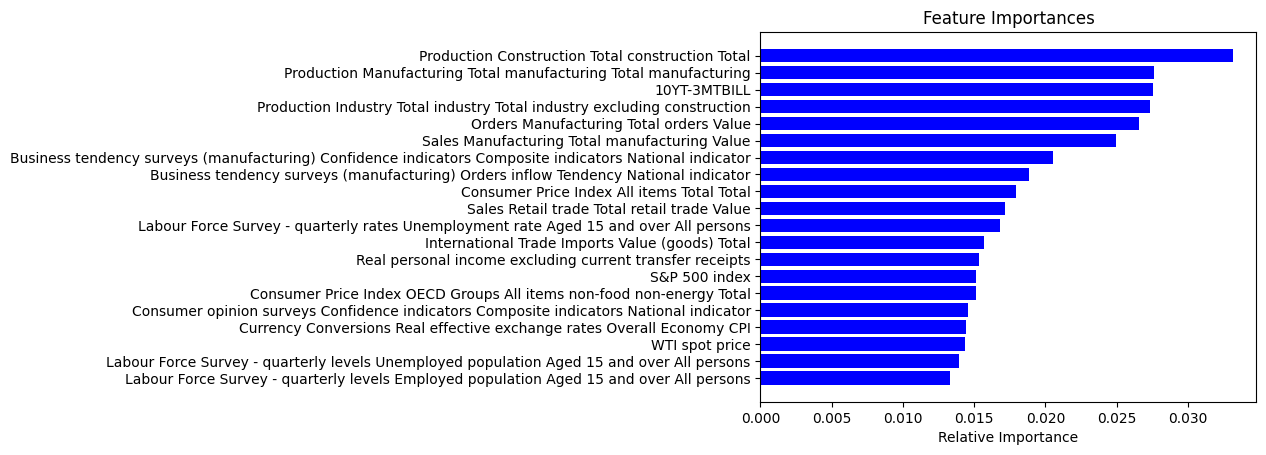

[('PRCNTO01', 'Production Construction Total construction Total'), ('PRMNTO01', 'Production Manufacturing Total manufacturing Total manufacturing'), ('103SPREAD', '10YT-3MTBILL'), ('PRINTO01', 'Production Industry Total industry Total industry excluding construction'), ('ODMNTO02', 'Orders Manufacturing Total orders Value'), ('SLMNTO02', 'Sales Manufacturing Total manufacturing Value'), ('BSCICP02', 'Business tendency surveys (manufacturing) Confidence indicators Composite indicators National indicator'), ('BSOITE02', 'Business tendency surveys (manufacturing) Orders inflow Tendency National indicator'), ('CPALTT01', 'Consumer Price Index All items Total Total'), ('SLRTTO02', 'Sales Retail trade Total retail trade Value'), ('LRUNTTTT', 'Labour Force Survey - quarterly rates Unemployment rate Aged 15 and over All persons'), ('XTIMVA01', 'International Trade Imports Value (goods) Total'), ('W875RX1', 'Real personal income excluding current transfer receipts'), ('SP500', 'S&P 500 index'),

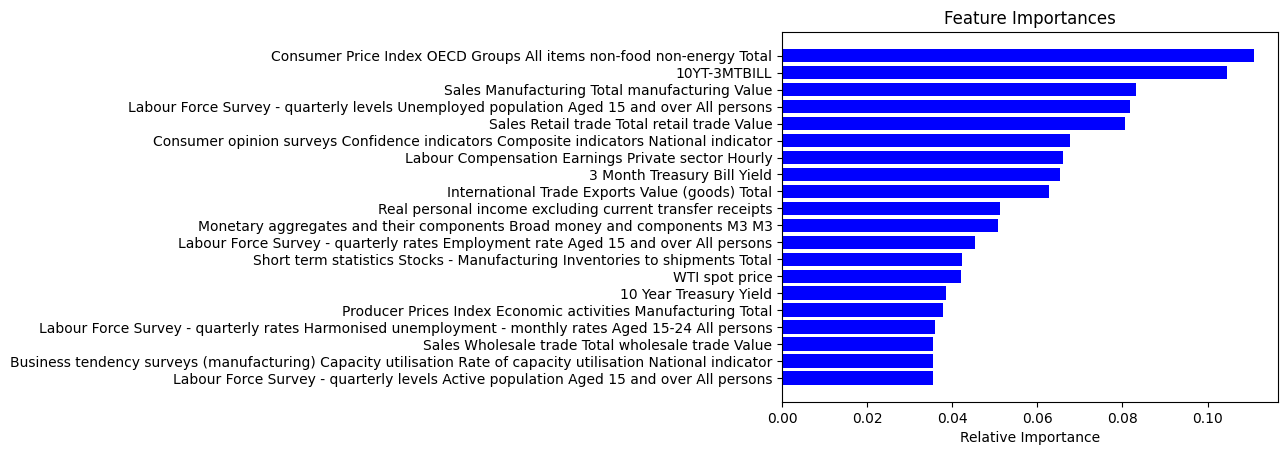

[('CPGRLE01', 'Consumer Price Index OECD Groups All items non-food non-energy Total'), ('103SPREAD', '10YT-3MTBILL'), ('SLMNTO02', 'Sales Manufacturing Total manufacturing Value'), ('LFUNTTTT', 'Labour Force Survey - quarterly levels Unemployed population Aged 15 and over All persons'), ('SLRTTO02', 'Sales Retail trade Total retail trade Value'), ('CSCICP02', 'Consumer opinion surveys Confidence indicators Composite indicators National indicator'), ('LCEAPR01', 'Labour Compensation Earnings Private sector Hourly'), ('3MTBILL', '3 Month Treasury Bill Yield'), ('XTEXVA01', 'International Trade Exports Value (goods) Total'), ('W875RX1', 'Real personal income excluding current transfer receipts'), ('MABMM301', 'Monetary aggregates and their components Broad money and components M3 M3'), ('LREMTTTT', 'Labour Force Survey - quarterly rates Employment rate Aged 15 and over All persons'), ('STMNIS01', 'Short term statistics Stocks - Manufacturing Inventories to shipments Total'), ('WTI', 'WTI 

In [12]:
################# assign here! ########################
label=1 ## label = class (1 for positive class, 0 for negative class)
version='train' ## 'train' or 'test'
idx=0 ## rank = idx + 1
##############################################################

for idx in [0,1,2,3,4]:

  print('Top {} ranked model {}'.format(idx+1, model_name_list[idx]))
  selected_features=features_list[idx]
  values_train=shap_train[idx]
  values_test=shap_test[idx]
  trainx=data[idx][0]
  testx=data[idx][2]

  if version=='train':
      values=values_train
      x=trainx
  else:
      values=values_test
      x=testx


  ft_imp=abs(np.sum(values, axis=2)[label]).mean(0)

  df=pd.DataFrame({'feature':selected_features, 'ft_imp':ft_imp}).sort_values('ft_imp', ascending=False)[:20]
  df['name']=df['feature'].apply(lambda x:metadata[metadata.SUBJECT==x]['Name'].values[0])
  plt.title('Feature Importances')
  plt.barh(df.name, df.ft_imp, color='b', align='center')
  plt.xlabel('Relative Importance')
  plt.gca().invert_yaxis()
  plt.show()
  print(list(zip(df.feature, [metadata[metadata.SUBJECT==x]['Name'].values[0] for x in df.feature])))

## plot SHAP summary plot for {idx+1} ranked model


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


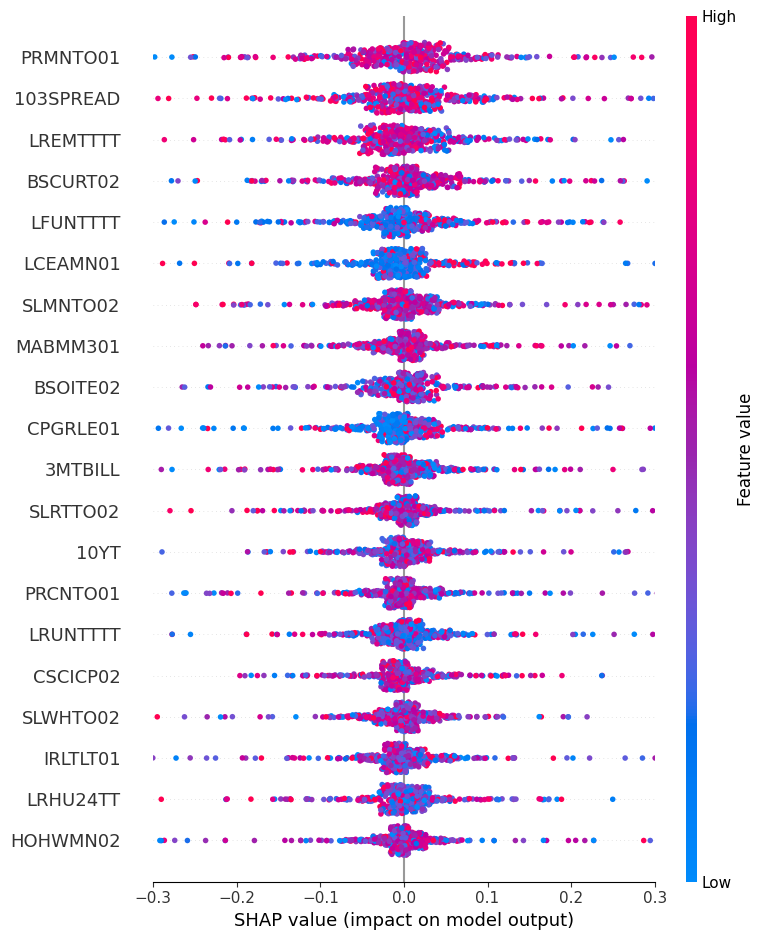

In [13]:
#################### assign here! ###########################
label=1  ## label = class (1 for positive class, 0 for negative class)
version='train' ## 'train' or 'test'
idx=0 ## rank = idx +1
##############################################################

selected_features=features_list[idx]
values_train=shap_train[idx]
values_test=shap_test[idx]
trainx=data[idx][0]
testx=data[idx][2]

if version=='train':
    values=values_train
    x=trainx
else:
    values=values_test
    x=testx

## reduce dimension of (sample * timestep * features) ==> (sample * features)
## for shap_values, sum across timesteps
## for feature value, average across timesteps
shap.summary_plot(np.sum(values, axis=2)[label], np.mean(x, axis=1),selected_features, show=False)
ax = plt.gca()
# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(-0.3, 0.3)
plt.show()

In [14]:
ft_imp

array([0.06612849, 0.01794681, 0.02705859, 0.05072609, 0.02574758,
       0.04231488, 0.03544879, 0.02791233, 0.06278545, 0.01980423,
       0.01802936, 0.02818364, 0.08052785, 0.08308444, 0.0211187 ,
       0.02280623, 0.0280963 , 0.02005764, 0.01623404, 0.03785114,
       0.03538819, 0.03302258, 0.0247941 , 0.081762  , 0.11104232,
       0.02506784, 0.05114147, 0.0308123 , 0.04208529, 0.03511359,
       0.0119258 , 0.01978405, 0.01587595, 0.06765522, 0.01773002,
       0.02136941, 0.02446529, 0.02875953, 0.04528189, 0.03590026,
       0.02371371, 0.03543535, 0.06532238, 0.03841119, 0.10458489])

## plot SHAP dependence plot for specified feature list for {idx+1} ranked model


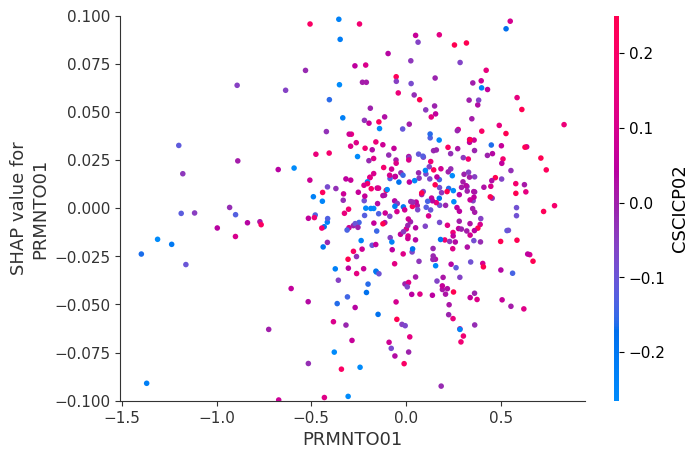

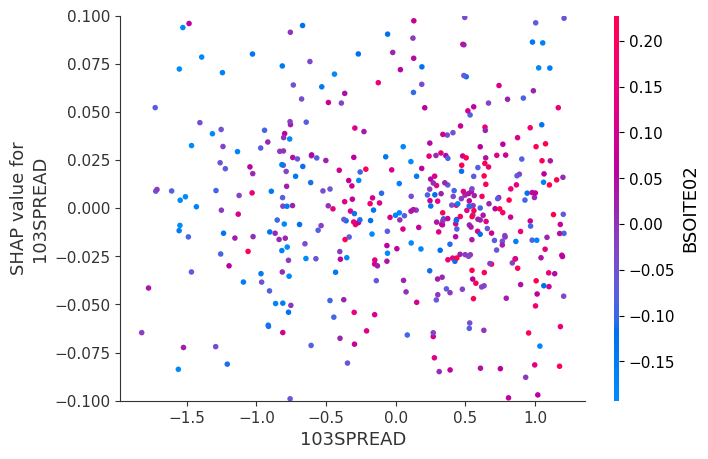

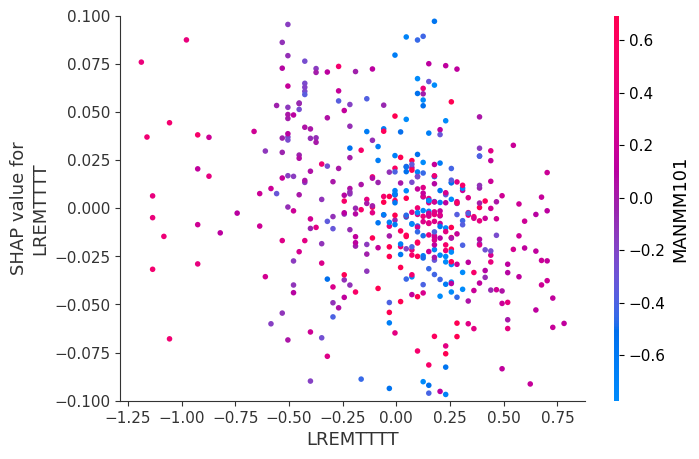

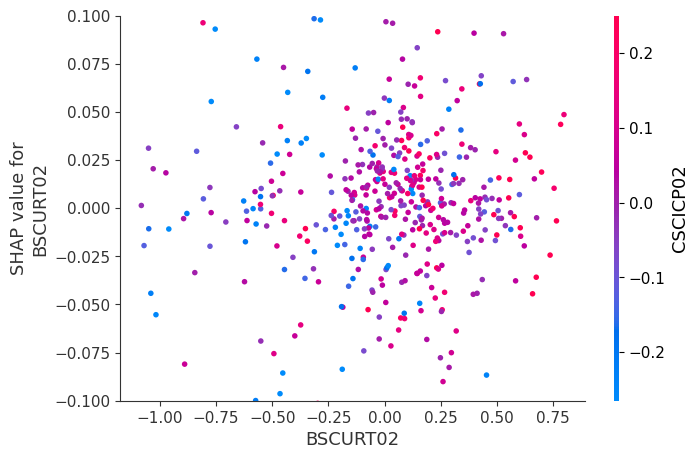

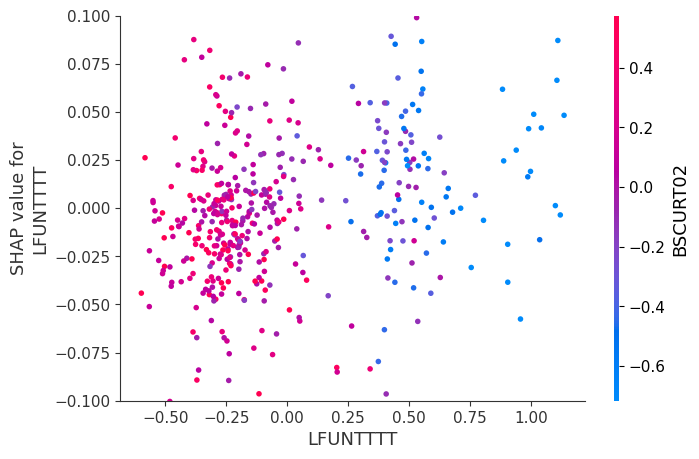

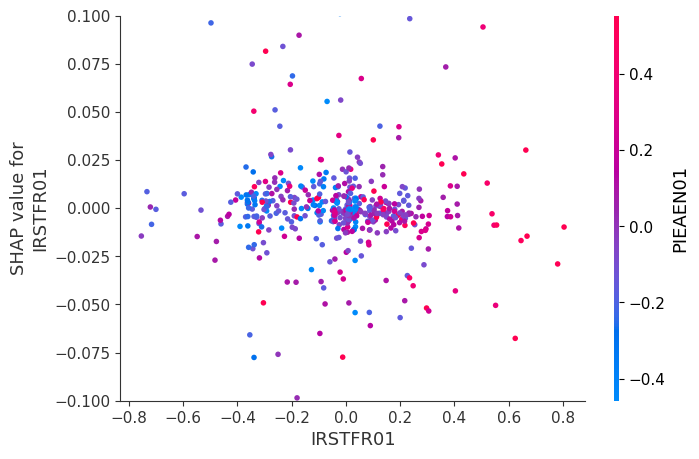

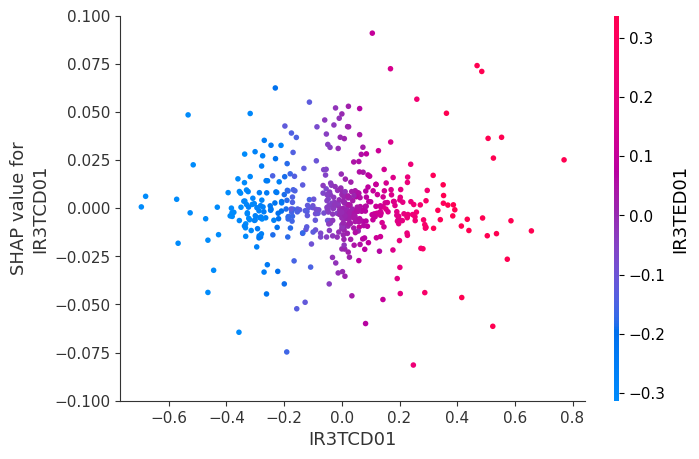

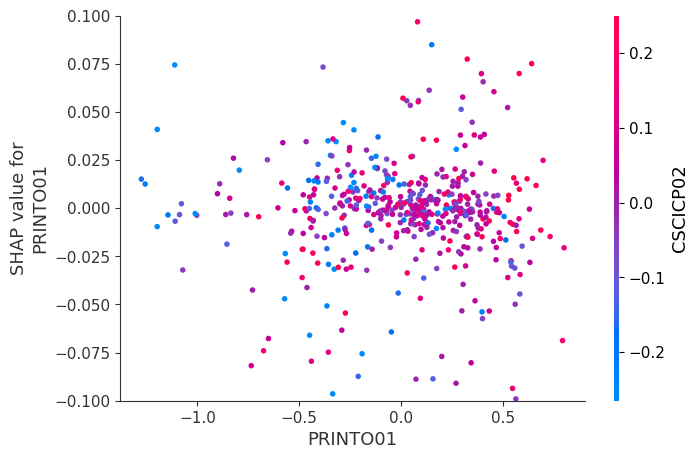

In [19]:
#################### assign here! ###########################
label=1  ## label = class (1 for positive class, 0 for negative class)
version='train' ## 'train' or 'test'
idx=0 ## rank = idx +1
##############################################################

selected_features=features_list[idx]
values_train=shap_train[idx]
values_test=shap_test[idx]
trainx=data[idx][0]
testx=data[idx][2]

if version=='train':
    values=values_train
    x=trainx
else:
    values=values_test
    x=testx

ft_imp=abs(np.sum(values, axis=2)[label]).mean(0)
df=pd.DataFrame({'feature':selected_features, 'ft_imp':ft_imp}).sort_values('ft_imp', ascending=False)[:5]

#################### add more features here! ###########################
variable_list=list(df.feature)+['IRSTFR01','IR3TCD01','PRINTO01']
##############################################################

for variable in variable_list:

  var_idx=selected_features.index(variable)

  ## reduce dimension of (sample * timestep * features) ==> (sample * features)
  ## for shap_values, sum across timesteps for each observation
  shap.dependence_plot(var_idx, np.sum(values, axis=2)[label], np.mean(x, axis=1), feature_names=selected_features, show=False)
  ax = plt.gca()

  ax.set_ylim(-0.1, 0.1)
  plt.show()

## plot SHAP force plot for the COVID-19 pandemic case study


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


2020-02-01 00:00:00


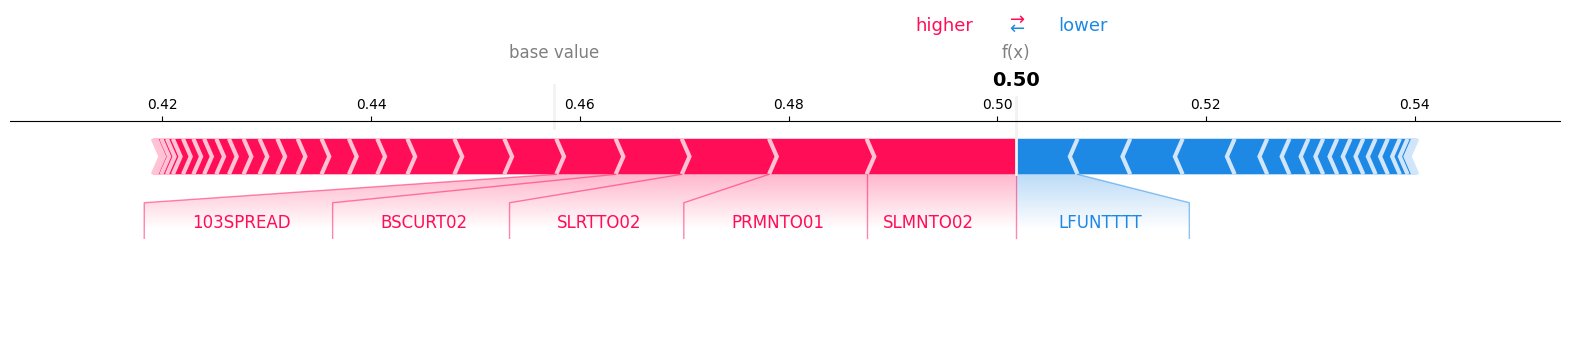

2020-03-01 00:00:00


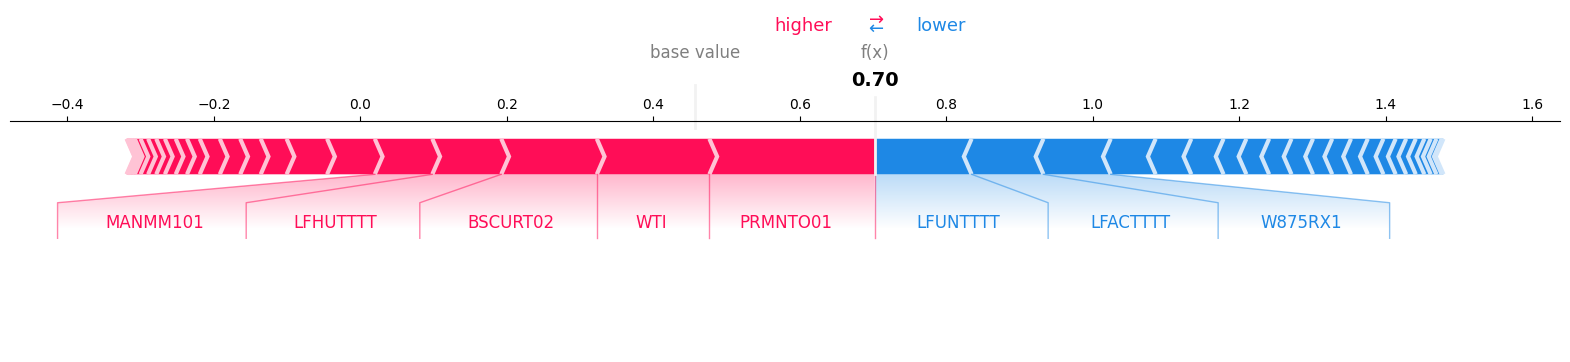

2020-04-01 00:00:00


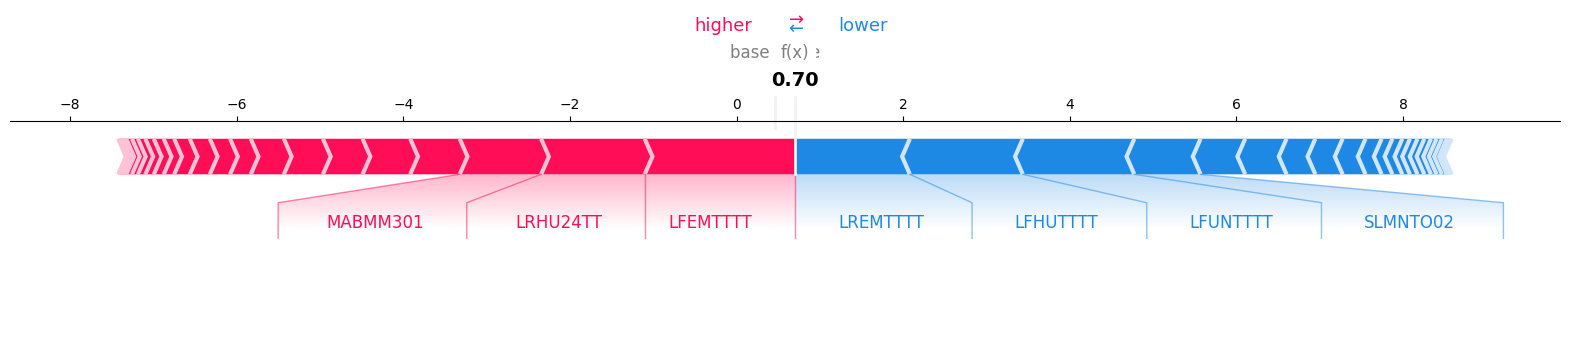

2020-05-01 00:00:00


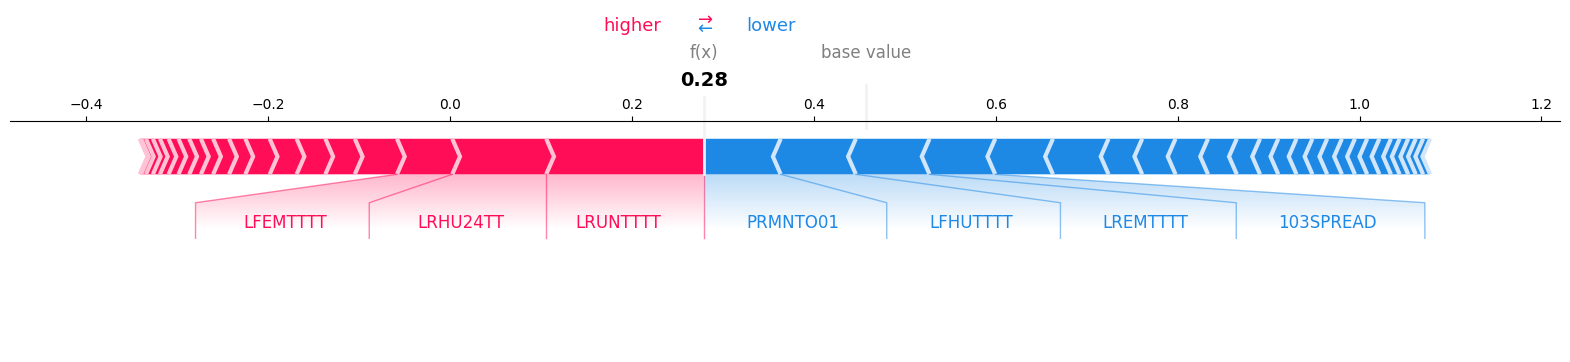

In [16]:
#################### assign here! ###########################
label=1  ## label = class (1 for positive class, 0 for negative class)
version='test' ## 'train' or 'test'
t_list=[x[0] for x in np.argwhere(y_test)]  ## index of positive(non-zero) case in test dataset
t_name_list=y_data[-test_year*12:][t_list].index
y_test
idx=0 ## rank = idx + 1
##############################################################

selected_features=features_list[idx]
values_train=shap_train[idx]
values_test=shap_test[idx]
trainx=data[idx][0]
model_name=model_name_list[idx]
final_model=load_model(path+'/model/{}_top{}_alltrained.h5'.format(model_name, idx))
explainer=shap.DeepExplainer(final_model, trainx)

if version=='train':
    values=values_train
else:
    values=values_test

for month, t in zip(t_name_list, t_list):
  print(month)
  value_ft_t=np.sum(values[label][t], axis=0)
  shap.initjs()
  shap.force_plot(explainer.expected_value[label], value_ft_t, selected_features, matplotlib=True)
  shap.force_plot(explainer.expected_value[label], values[label][t], selected_features)